In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import normal, seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, probability_v2
from sklearn.cluster import KMeans

In [6]:
rats = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150.npy')
lengths = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy')

to_be_removed = '.ipynb_checkpoints'

root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
normal_trajs = os.listdir(root_dir + 'normal')
drug_trajs_1 = os.listdir(root_dir + 'caffeine')
drug_trajs_2 = os.listdir(root_dir + 'amphetamine')


if to_be_removed in normal_trajs:
    idx = normal_trajs.index(to_be_removed)
    normal_trajs.pop(idx)
    
if to_be_removed in drug_trajs_1:
    idx = drug_trajs_1drug_trajs_1.index(to_be_removed)
    drug_trajs_1.pop(idx)

if to_be_removed in drug_trajs_2:
    idx = drug_trajs_2.index(to_be_removed)
    drug_trajs_2.pop(idx)

names = normal_trajs + drug_trajs_1 + drug_trajs_2

print(rats.shape)

(6480000, 60)


In [7]:
def mPE__(*argv):    
    g=len(argv)
    
    if g==2:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=np.array([1])
    if g==3:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=argv[2]
    if g==4:
        n=argv[1]
        datain=argv[0]
        lamin=argv[3]
        epsin=argv[2]
    
#    Check for the data to be in the right dimension        
    if datain.shape[0] == 1 or datain.shape[1] == 1:
        if len(datain[:,0])>len(datain[0,:]):
            datain=datain.transpose()
    else:
        if len(datain[:,1])>len(datain[1,:]):
            datain=datain.transpose()
        
    scalesno=len(epsin)
    lagno=len(lamin)
    HH=np.zeros((lagno,scalesno))
    norm_HH=np.zeros((lagno,scalesno))
#    Definition of parameters: fac is the number of possible permutations
#    Elem is the No of data points
#    Dim is the dimensionality of the samples
    
    for lam in range(0,lagno):
        for eps in range(0,scalesno):
            scale=epsin[eps]
            L=lamin[lam]
            xlen=len(datain[0,:])
            ylen=np.round((xlen/scale)-0.5)
            ylen=ylen.astype(int)
            D=np.zeros((len(datain[:,0]),ylen))
            for ylenc in range(0,ylen):
                dfg=datain[:,((ylenc)*scale):((ylenc+1)*scale)]
                fhk=np.sum(dfg,axis=1)
                r=(1/scale)*fhk
                D[:,ylenc]=r
                
            data=D
            fac=mt.factorial(n)
            elem=len(data[0,:])
            dim=len(data[:,0])
            
        #    A is a n-by-factorial(n) matrix that shows all the 
        #    possible permutations of n elements
            A=permutation(n)
            
        #    counter is a factorial(n) square matrix that counts the recurrence of
        #    a dim-dimensional permutation
            lpi=fac*np.ones((dim))
            lpi=lpi.astype(int)
            nj = lpi.tolist()
            counter=np.zeros((nj))
            
        #    For each iteration i, a series of n points is sampled from the 
        #    data set and the corresponding permutation is identified. 
        #    The counter matrix keeps track of the numiber of times a certain
        #    permutation, or combination of permutations is observed. 
            for i in range(0, elem-n*L+L-1):
                coord=np.zeros((dim))
                for num in range(0,dim):
                    sample=data[num,range(i,i+L*(n),L)]
                    ord=ubble(sample)
                    perm_num=0
                    check_1=1
                    check_2=1
                    
                    while (perm_num<=fac) and (check_2):
                       
                        check_1=1
                        for j in range(0,n-1):
                            if ord[j]!=A[perm_num,j]:
                                check_1=0
                        if check_1:
                            coord[num]=perm_num
                            check_2=0
                            
                        perm_num=perm_num+1
                
                    
                coord=coord.astype(int)
                coord1=tuple(coord)
                counter[coord1]=counter[coord1]+1
                
        #    Once the counter matrix is complete, each element is divided by the
        #    total number of samples to get a empirical probability, and the PE is
        #    computed according to the method described in Schurmann
            
            H=0
            counter1=counter.flatten()
            for iter in range(0,(fac**dim)):
               
                rec=counter1[iter]
                tot=elem-n+1
                
                if rec==0:
                    H=H
                    
                else:
                    I = quad(integrand, 0, 1, args=(rec))
                    I=I[0]
                    coeff=((-1)**rec)*I
                    prob=(rec/tot)*(psi.digamma(tot)-psi.digamma(rec)-coeff)
                    H=H+mt.log2(mt.exp(prob))
                 
        #     The normalised entropy norm_H is computed as well
            norm_H=H/(mt.log2(fac**dim))
            
            HH[lam,eps]=H
            norm_HH[lam,eps]=norm_H
    return [HH,norm_HH]

In [8]:
def get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random):
    if random:
        bins_number = 4
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        print(mPE_vector.shape)

        for i in range(bins_number):
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                traj = reduced_traj[idx_1: idx_1 + traj_length]
                [HH, _]=mPE__(traj, orders[0])
                mPE_vector[i, idx, 0] = HH
                idx +=1

    else:
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        
        for a, order in enumerate(orders):
            
            for i in range(bins_number):
                idx = 0
                
                for j in range(0, traj_length*traj_number, traj_length):
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                        
                    if traj.shape[0]>0:
                        [HH, _]=mPE__(traj, order)
                        mPE_vector[i, idx, a] = HH
                        
                    idx +=1
    
    
    return mPE_vector

traj_1
signal shape:  (6480000, 60)
########################## APPLY PCA ##########################


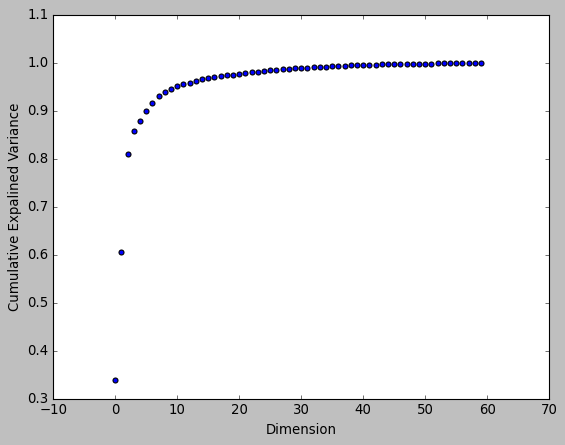

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################
6 18


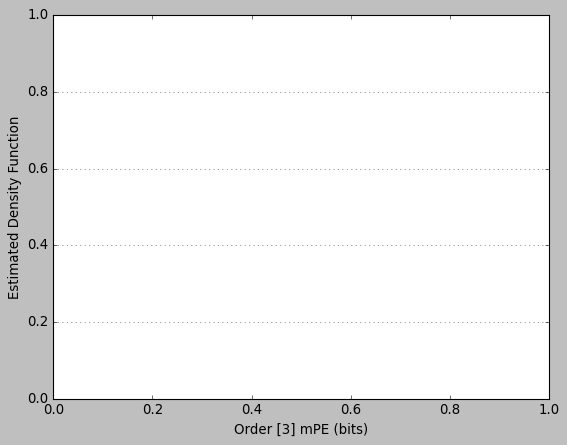

traj_2
signal shape:  (0, 60)
########################## APPLY PCA ##########################


ValueError: Found array with 0 sample(s) (shape=(0, 60)) while a minimum of 1 is required.

In [12]:
###################################################################################################################################################
####################################################################### PCA #######################################################################
###################################################################################################################################################

significance_level = 0.05
n_clusters_kmeans = 15
decimals = 3
unit_length_entropy = 3000
save = True
nPCs = [3]
max_length = 334800

use_all = False ## DONE
use_partition_up = True
use_partition_down = False 
use_single = False 

if use_single:
    nPCs = [3]
    dims = np.arange(9,12)
    use_PCA = False
    add_on = '_marker'

if use_partition_up:
    nPCs = [3]
    dims_1 = np.arange(24)
    dims_2 = np.arange(36,42)
    use_PCA = True
    add_on = '_partition_up'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)

if use_partition_down:
    nPCs = [3]
    dims_1 = np.arange(24,36)
    dims_2 = np.arange(42,60)
    use_PCA = True
    add_on = '_partition_down'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)
    
if use_all:
    dims = np.arange(60)
    use_PCA = True
    
    
for n_PC in nPCs:
    
    count = 0
    
    for which_traj, length in enumerate(lengths):

        if count <= 3:
            mode = 'normal'
        elif count >= 4 and count <=7:
            mode = 'caffeine'
        else:
            mode = 'amphetamine'

        name = names[count]
        print(name)

        if which_traj == 0:
            idx = 0
        else:
            idx += lengths[which_traj-1]

        traj = rats[idx:idx+length, :]
        
        print('signal shape: ', traj.shape)
        
        ##### PCA #####
        if use_PCA:

            print('########################## APPLY PCA ##########################')

            pca = PCA()
            pca.fit(traj)

            explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]

            plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
            plt.ylabel('Cumulative Expalined Variance')
            plt.xlabel('Dimension')

            plt.show()

            # reduce data according to explained variance values using linear PCA
            pca = PCA(n_components=n_PC)
            reduced_traj = pca.fit_transform(traj)
            if reduced_traj.shape[0] > max_length:
                reduced_traj = reduced_traj[0:max_length, :]

        else:
            if traj.shape[0] > max_length:
                reduced_traj = traj[0:max_length, dims]

        print('signal shape: ', reduced_traj.shape)
        
        ##### Control vector assemble #####
        if count == 0 or count ==  4 or count == 8:
            control_vector = reduced_traj
        else:
            control_vector = np.concatenate((control_vector, reduced_traj),axis=0)
        
        ###################################################################################################################################################
        ########################################################### CONTROL ANALYSIS ######################################################################
        ###################################################################################################################################################
        
        ########## Take random trajectories and check that they have approximately the same mPE ##########
        
        if count == 3 or count ==  7 or count == 11:
            print(control_vector.shape)
            print('########################## CONTROL ANALYSIS ##########################')

            unit_length = unit_length_entropy
            minutes = 30
            bin_length = 30*60*minutes
            bins_number = int(control_vector.shape[0]/bin_length)
            traj_number = int(bin_length/unit_length)
            orders = [3]
            random = True

            too_low = True
            
            while too_low == True:
                
                mPE_vector = get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random=True)
                
                ########## calculate p-value ##########
                [_, p_value_1] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])
                [_, p_value_2] = stats.ks_2samp(mPE_vector[1, :, 0], mPE_vector[2, :, 0])
                [_, p_value_3] = stats.ks_2samp(mPE_vector[2, :, 0], mPE_vector[3, :, 0])
                
                if p_value_1 and  p_value_2 and p_value_3 > 0.3:
                    too_low = False
                    break

            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time' + str(add_on) + '/micro/' + str(n_PC) + 'PC/control/' + mode + '/' + name + '.npy'
            np.save(path_out, mPE_vector)

            ########## Retrieve maxiumum number of elements based on a raw decimal discretization ##########
            data = mPE_vector.flatten()
            kmeans = KMeans(n_clusters=n_clusters_kmeans).fit(data.reshape(-1,1))
            kmeans.predict(data.reshape(-1,1))
            centroids = kmeans.cluster_centers_
            centroids = [centroids[i] for i in range(len(centroids))]
            centroids = np.asarray(centroids)

            ########## Get probability vectors ##########
            prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
            prob2 = probability_v2(mPE_vector[1, :, 0], centroids)
            prob3 = probability_v2(mPE_vector[2, :, 0], centroids)
            prob4 = probability_v2(mPE_vector[3, :, 0], centroids)

            ########## Evaluation ##########
            js_distance = distance.jensenshannon(prob1, prob2)
            js_distance = distance.jensenshannon(prob2, prob3)
            js_distance = distance.jensenshannon(prob3, prob4)


        ###################################################################################################################################################
        ########################################################### ENTROPY ANALYSIS ######################################################################
        ###################################################################################################################################################


        print('########################## ENTROPY ANALYSIS ##########################')

        ########## Entropy Calculation ##########
        unit_length = unit_length_entropy
        minutes = 30
        bin_length = 30*60*minutes
        bins_number = int(reduced_traj.shape[0]/bin_length)
        traj_number = int(bin_length/unit_length)
        
        orders = [3]
        
        print(bins_number, traj_number)

        ########## Calculate mPE vector ##########
        mPE_vector = get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random=False)
        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time' + str(add_on) + '/micro/' + str(n_PC) + 'PC/result/' + mode + '/' + name + '.npy'
        # np.save(path_out, mPE_vector)

        ########## Retrieve maxiumum number of elements based on k-means discretization ##########
        data = mPE_vector.flatten()
        kmeans = KMeans(n_clusters=n_clusters_kmeans).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        ########## plotting mPE continuous distribution as a function of time ##########        
        fig = plt.figure()
        compare_to = mPE_vector[0, :, 0]
        p_value_array = np.zeros((bins_number-1, ))
        js_array = np.zeros((bins_number-1, ))
        

        for bin_n in range(1, bins_number):
            [_, p_value] = stats.ks_2samp(mPE_vector[bin_n, :, 0], compare_to)
            p_value_array[bin_n -1] = p_value

            prob1 = probability_v2(compare_to, centroids)
            prob2 = probability_v2(mPE_vector[bin_n, :, 0], centroids)

            js_distance = distance.jensenshannon(prob1, prob2)
            js_array[bin_n -1] = js_distance   

            if p_value <= significance_level:
                ax = sns.kdeplot(mPE_vector[bin_n, :, 0])
                compare_to = mPE_vector[bin_n, :, 0]

        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Order [3] mPE (bits)')
        plt.ylabel('Estimated Density Function')

        plt.show()

        count +=1